---
layout: default
categories: "DataScience"
permalink: /:categories/:title
title: "ML Walk-through 1 - Part 2 of 5"
---

# Model: Benchmark Classifier

In this 5 part walk-through, I'll demonstrate a simple Machine Learning project to build a classifier model.

In this step, we will quickly train and test a __simple, benchmark model__ on the data we have collected, which gives us the following:

1. A benchmark to compare later models against.
2. To figure out most suitable comparison metric (__hint__: look at benchmark model, project scope).
3. An insight into the dataset and the problem before we begin EDA.
<!--end-excerpt-->

ML Walk-through Series:

1. Project Scoping and Data Collection
2. Initial Model
3. Exploratory Data Analysis
4. Data Processing
5. Final Model


## 1.a. Import: Libraries

In [1]:
#data organizing
import pandas #storage
import numpy as np #data-type conversion
from os import getcwd

#preprocessing - data splitting
from sklearn.model_selection import train_test_split

#classifier
from sklearn.tree import DecisionTreeClassifier

#classification result - statistical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#classifier result - graphical
from sklearn.model_selection import learning_curve

#hyper-parameter optimization
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot

## 1.b. Import: Dataset

In [2]:
#dtype changed from int64 to int32 to save space and speed up computation, no data was lost
def cvDefPay(prediction):
    mapper = {0: False, 1: True}
    return mapper.get(prediction)

url = getcwd() + '\\default of credit card clients.xls'
ccd = pandas.read_excel(io = url, \
                        sheet_name='Data', header = 1, index_col = 0, \
                        dtype = {'LIMIT_BAL': np.int32, 'AGE': np.int32, 'BILL_AMT1': np.int32, 'BILL_AMT2': np.int32, 'BILL_AMT3': np.int32, 'BILL_AMT4': np.int32, 'BILL_AMT5': np.int32, 'BILL_AMT6': np.int32, 'PAY_AMT1': np.int32, 'PAY_AMT2': np.int32, 'PAY_AMT3': np.int32, 'PAY_AMT4': np.int32, 'PAY_AMT5': np.int32, 'PAY_AMT6': np.int32}, \
                       converters = {'default payment next month': cvDefPay})

In [3]:
ccd.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)
ccd.rename(columns = {'default payment next month': 'default_payment_next_month'}, inplace = True)

In [4]:
ccdY = pandas.DataFrame(ccd['default_payment_next_month'])
ccdX = ccd.drop(['default_payment_next_month'], axis = 'columns')

## 3. Data Splitting

Though GridSearchCV uses Stratified K-Fold cross-validation, test dataset is separated so that model's accuracy can be tested independently.


In [5]:
trainX, testX, trainY, testY = train_test_split(ccdX, ccdY, test_size = 0.25, stratify = ccdY, random_state = 44)

## 4.a. GridSearchCV: DecisionTreeClassifier

Why GridSearchCV?

1. Since it's the initial stages of our machine learning project, we lack the insight to properly tune the parameters of even a simple classifier like DecisionTree, hence we can provide a wide range of parameters through this approach.
2. Cross validation i.e. CV so that we can train and compare model with various parameter sets without exposing test dataset to it.

Why DecisionTree?

Because it's one of the simpler classification algorithms.

What is Scoring Metric?

the metric we will use to compare the models

__Important__: At this point, we are unlikely to have good enough insight to select a very good scoring metric, so we'll just pick a few relevant ones with insights from project scope/problem's literature review.

In [6]:
featureCount = len(ccdX.columns)

parameterGrid = {'max_depth': [featureCount * 0.125, featureCount * 0.25, featureCount * 0.5, featureCount * 0.75, featureCount],
                 'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random']}

scoringMetrics = ['recall', 'accuracy', 'roc_auc']

gridSearch = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 39),
    param_grid = parameterGrid,
    scoring = scoringMetrics,
    n_jobs = -1, #https://scikit-learn.org/stable/glossary.html#term-n-jobs
    cv = 5, #5 fold stratified cross-validator
    refit = 'recall',
    return_train_score = True)

In [7]:
gridSearch.fit(trainX, trainY.values.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=39), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2.875, 5.75, 11.5, 17.25, 23],
                         'splitter': ['best', 'random']},
             refit='recall', return_train_score=True,
             scoring=['recall', 'accuracy', 'roc_auc'])

In [10]:
classifier = gridSearch.best_estimator_

In [11]:
gridSearch.best_estimator_

DecisionTreeClassifier(max_depth=23, random_state=39)

## 4.b. Classification Result - Statistical

In [12]:
classifier.score(trainX, trainY)

0.9737333333333333

In [13]:
classifier.score(testX, testY)

0.7461333333333333

In [14]:
predictY = classifier.predict(testX)
print(classification_report(testY, predictY))

              precision    recall  f1-score   support

       False       0.83      0.85      0.84      5841
        True       0.42      0.39      0.41      1659

    accuracy                           0.75      7500
   macro avg       0.63      0.62      0.62      7500
weighted avg       0.74      0.75      0.74      7500



In [15]:
roc_auc_score(testY, predictY)

0.6201506900927627

In [16]:
pandas.DataFrame(
    confusion_matrix(testY, predictY),
    columns=['Predicted | Not Defaulter', 'Defaulter'],
    index=['Correct | Not Defaulter', 'Defaulter'])

,Predicted | Not Defaulter,Defaulter
Correct | Not Defaulter,4942,899
Defaulter,1005,654


## 4.c. Classification Result - Graphical

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y).
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring=scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

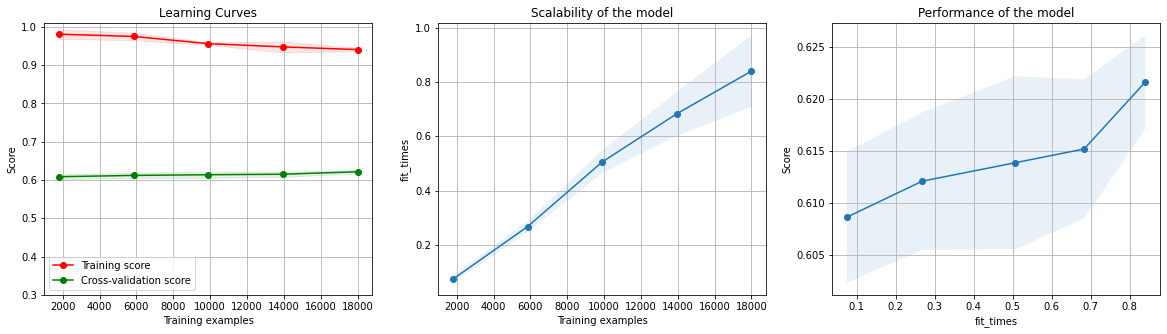

In [19]:
plot_learning_curve(estimator=classifier, title="Learning Curves", X=trainX, y=trainY, ylim=(0.3, 1.01),
                    cv=5, scoring="balanced_accuracy", n_jobs=-1).show()

### Interpreting the learning curves:

The left-most graph is the most relevant one here. It in, our test and cross-validation scores should be converging towards each-other as we move away from the x-axis origin.

Training score is the theoretical maximum score achievable with the dataset and the model in their current states, cross-validation score is what has been achieved.


## Choosing metric to compare models with:

Project scope/Problem's literature review suggests that:

1. We have a binary classification problem at hand.
2. Since we have to identify potential defaulters, we'll have to pay relatively higher attention to this class.
3. However, we can't ignore the non-defaulter class either, since incorrectly labeling them will likely result in slow, eventual erosion of credit card holders' trust, which will lead to financial loss.

Benchmark model's confusion metric and learning curve suggests that:

1. The classes are imbalanced.
2. Looking at the recall and precision scores respectively for both classes, we can conclude that correctly identifying Defaulter (statistical minority) class is relatively difficult.

Hence, we should prioritize individual defaulter datapoint over the non-defaulter, but keep things balanced overall. Also, our focus is on correctly identifying rightfully labeled datapoints.

Hence we should focus on recall metric for both classes, conclusively, we will use the macro average recall aka balanced accuracy metric for comparing models' performance.

<sup><sub>
Posted: 18th September, 2021, 13:20 UTC+5:30  
</sub></sup>